# Create initial conditions for Pb

September, 2019

In [3]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import matplotlib
from mpl_toolkits.basemap import Basemap
import cmocean
import csv
import pandas as pd
import pickle
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%matplotlib notebook

In [115]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
mesh = nc.Dataset('/ocean/brogalla/GEOTRACES/analysis-birgit/notebooks/ANHA12/ANHA12_mesh1.nc')
mesh_lon = np.array(mesh.variables['nav_lon'])
mesh_lat = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['tmask'][0,:,:,:])
cond = (mesh_bathy > 0.1)
bathy_masked = np.ma.masked_where(cond, mesh_bathy)

In [5]:
m      = nc.Dataset('/data/brogalla/run_storage/trial3/spin-up0/ANHA12_EXH006_2002_monthly.nc')
mdepth = np.array(m.variables['deptht'])
mlons  = np.array(m.variables['nav_lon'])
mlats  = np.array(m.variables['nav_lat'])

### Load Pb data:

In [6]:
folder= '/ocean/brogalla/GEOTRACES/data/'

GEOTRACES cruise CAA (and Canada Basin)

In [7]:
CAA = pd.read_csv(folder+'Pb-paper-data.csv')
CAA_lons     = CAA['station lon'].dropna().astype('float').values[1:]
CAA_lats     = CAA['Station lat'].dropna().astype('float').values[1:]
CAA_names    = CAA['Station names'].dropna().astype('str')
CAA_Pb_short = [CAA['CB3'].dropna().astype('float').values, \
                CAA['CB4'].dropna().astype('float').values, \
                CAA['LS2'].dropna().astype('float').values, \
                CAA['BB1'].dropna().astype('float').values]
CAA_Pb       = [CAA['LS2'].dropna().astype('float').values, \
                CAA['BB1'].dropna().astype('float').values, \
                CAA['BB2'].dropna().astype('float').values, \
                CAA['BB3'].dropna().astype('float').values, \
                CAA['CAA1'].dropna().astype('float').values, \
                CAA['CAA2'].dropna().astype('float').values, \
                CAA['CAA3'].dropna().astype('float').values, \
                CAA['CAA4'].dropna().astype('float').values, \
                CAA['CAA5'].dropna().astype('float').values, \
                CAA['CAA6'].dropna().astype('float').values, \
                CAA['CAA7'].dropna().astype('float').values, \
                CAA['CAA8'].dropna().astype('float').values, \
                CAA['CAA9'].dropna().astype('float').values, \
                CAA['CB1'].dropna().astype('float').values, \
                CAA['CB2'].dropna().astype('float').values, \
                CAA['CB3'].dropna().astype('float').values, \
                CAA['CB4'].dropna().astype('float').values]

CAA_depth   = [CAA['Depth'][np.isfinite(CAA['LS2'])].astype('float'), \
               CAA['Depth.1'][np.isfinite(CAA['BB1'])].astype('float'), \
               CAA['Depth.2'][np.isfinite(CAA['BB2'])].astype('float'), \
               CAA['Depth.3'][np.isfinite(CAA['BB3'])].astype('float'), \
               CAA['Depth.4'][np.isfinite(CAA['CAA1'])].astype('float'), \
               CAA['Depth.5'][np.isfinite(CAA['CAA2'])].astype('float'), \
               CAA['Depth.6'][np.isfinite(CAA['CAA3'])].astype('float'), \
               CAA['Depth.7'][np.isfinite(CAA['CAA4'])].astype('float'), \
               CAA['Depth.8'][np.isfinite(CAA['CAA5'])].astype('float'), \
               CAA['Depth.9'][np.isfinite(CAA['CAA6'])].astype('float'), \
               CAA['Depth.10'][np.isfinite(CAA['CAA7'])].astype('float'), \
               CAA['Depth.11'][np.isfinite(CAA['CAA8'])].astype('float'), \
               CAA['Depth.12'][np.isfinite(CAA['CAA9'])].astype('float'), \
               CAA['Depth.13'][np.isfinite(CAA['CB1'])].astype('float'), \
               CAA['Depth.14'][np.isfinite(CAA['CB2'])].astype('float'), \
               CAA['Depth.15'][np.isfinite(CAA['CB3'])].astype('float'), \
               CAA['Depth.16'][np.isfinite(CAA['CB4'])].astype('float')]

GEOTRACES cruise North Atlantic

In [8]:
Pb = nc.Dataset(folder+'GEOTRACES_IDP2017_v2_Discrete_Sample_Data_5024209a_1.nc')

In [9]:
NA_lats   = np.array(Pb.variables['latitude'])
NA_lons   = np.array(Pb.variables['longitude'])-360
NA_depths = np.array(Pb.variables['var2'])
NA_time   = np.array(Pb.variables['date_time'])
Pb_NA     = np.array(Pb.variables['var5']) # in pmol/kg

In [10]:
condNA = np.logical_or( Pb_NA > 1e5, Pb_NA < -1e5)
masked_Pb_NA = np.ma.masked_where(condNA, Pb_NA)

Pb from Arctic Ocean (US)

In [11]:
df = pd.read_csv(folder+'Pb_rob_rember.csv', parse_dates=['DATE']).dropna()

In [12]:
AO_depths = np.array(df['CTDDEPTH'])
AO_lats   = np.array(df['LATITUDE'])
AO_lons   = np.array(df['LONGITUDE'])
AO_dPb    = np.array(df['Pb_(pMol)'])

Map of all cruise Pb station locations:

<IPython.core.display.Javascript object>


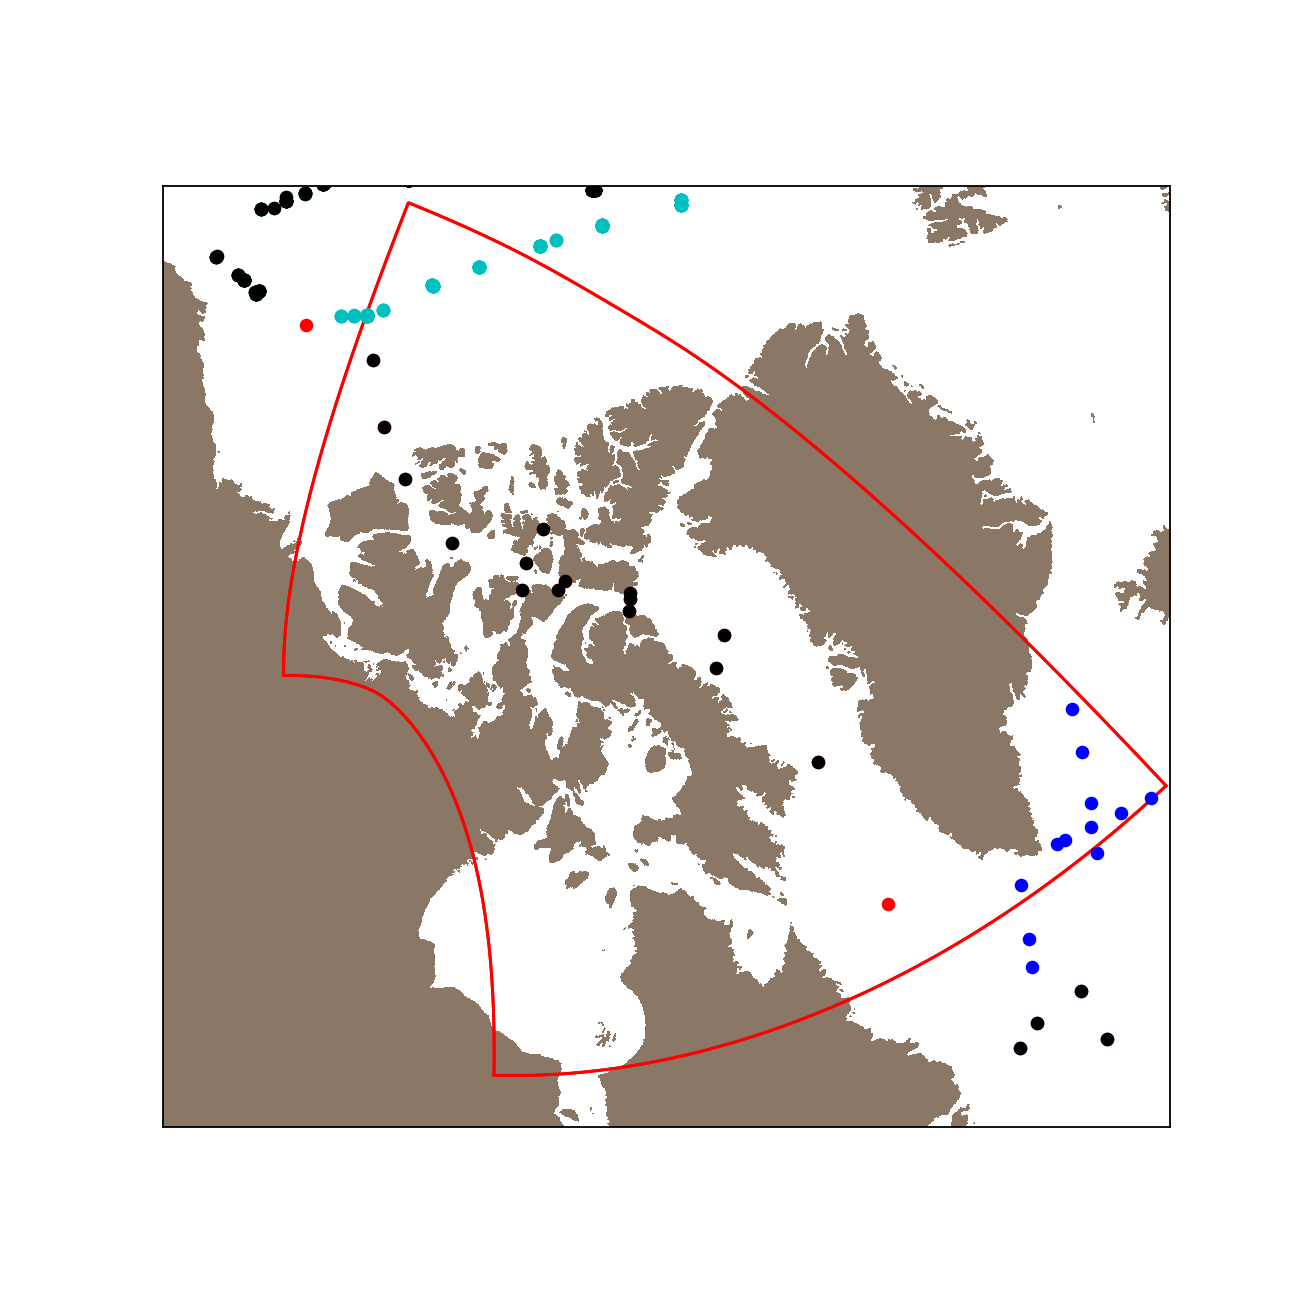

<IPython.core.display.Javascript object>

In [16]:
proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Pb.pickle','rb'))
x, y = proj(mesh_lon, mesh_lat)

# sub-domain:
l1=1100
proj.plot(x[l1:2050,799]   , y[l1:2050,799]   , 'r-', lw=1.3);
proj.plot(x[l1:2050,799].T , y[l1:2050,799].T , 'r-', lw=1.3);
proj.plot(x[l1:2050,160]   , y[l1:2050,160]   , 'r-', lw=1.3);
proj.plot(x[l1:2050,160].T , y[l1:2050,160].T , 'r-', lw=1.3);
proj.plot(x[l1,160:799]    , y[l1,160:799]    , 'r-', lw=1.3);
proj.plot(x[l1,160:799].T  , y[l1,160:799].T  , 'r-', lw=1.3);
proj.plot(x[2050,160:799]    , y[2050,160:799]    , 'r-', lw=1.3);
proj.plot(x[2050,160:799].T  , y[2050,160:799].T  , 'r-', lw=1.3);

# Canadian GEOTRACES station locations:
x_CAA, y_CAA = proj(CAA_lons, CAA_lats)
proj.plot(x_CAA, y_CAA, '.r', markersize=10)
proj.plot(x_CAA[1:16], y_CAA[1:16], '.k', markersize=10)

# North Atlantic GEOTRACES station locations:
x_NA, y_NA = proj(NA_lons, NA_lats)
proj.plot(x_NA, y_NA, '.b', markersize=10)
proj.plot(x_NA[NA_lats < 55], y_NA[NA_lats < 55], '.k', markersize=10)

# Arctic Ocean station locations:
x_AO, y_AO = proj(AO_lons, AO_lats)
proj.plot(x_AO, y_AO, '.c', markersize=10)
proj.plot(x_AO[0:144], y_AO[0:144], '.k', markersize=10)
proj.plot(x_AO[290:334], y_AO[290:334], '.k', markersize=10)

In [17]:
NA_lons_tot    = np.transpose(np.tile(NA_lons, (288,1)))
NA_lats_tot    = np.transpose(np.tile(NA_lats, (288,1)))

# Generalized function for kriging

Gaussian process regression. Kernel --- Rational quadratic

In [18]:
def krig(depth, CAA=False, \
         AO_lon=AO_lons, AO_lat=AO_lats, AO_depth=AO_depths, AO_dPb=AO_dPb, \
         NA_lons_tot=NA_lons_tot, NA_lats_tot=NA_lats_tot, NA_depths=NA_depths, NA_Pb=Pb_NA, \
         CAA_lons=CAA_lons, CAA_lats=CAA_lats, mesh_lon=mesh_lon, mesh_lat=mesh_lat):
    
    # input arguments:
    # - depth --- vector with two values indicating the range of depths that I want to create a field for
    # - CAA   --- whether or not to use CAA station data
    
    AOlons = AO_lon[(AO_depth < depth[1]) & (AO_depth > depth[0])]
    AOlats = AO_lat[(AO_depth < depth[1]) & (AO_depth > depth[0])]
    AOdPb  = AO_dPb[(AO_depth < depth[1]) & (AO_depth > depth[0])]    
    NAlons = NA_lons_tot[(NA_depths < depth[1]) & (NA_depths > depth[0])]
    NAlats = NA_lats_tot[(NA_depths < depth[1]) & (NA_depths > depth[0])]
    NAPb   = NA_Pb[(NA_depths < depth[1]) & (NA_depths > depth[0])]
    
    CAAlons = np.empty([])
    CAAlats = np.empty([])
    CAAPb   = np.empty([])
    
    if CAA:
        # For CAA stations, create a list of dPb, lons, lats with depths that fall within the range below
        for stn in range(0, len(CAA_Pb)):
            dpb_caa = CAA_Pb[stn][(CAA_depth[stn] < depth[1]) & (CAA_depth[stn] > depth[0])]
            lon_stn = np.tile(CAA_lons[stn], len(dpb_caa))
            lat_stn = np.tile(CAA_lats[stn], len(dpb_caa))
            CAAPb     = np.append(dpb_caa, CAAPb)
            CAAlons   = np.append(lon_stn, CAAlons)
            CAAlats   = np.append(lat_stn, CAAlats)       
    else:      
        # For CAA stations, create a list of dPb, lons, lats with depths that fall within the range below
        stns = [0, 16]
        for stn in stns:
            dpb_caa = CAA_Pb[stn][(CAA_depth[stn] < depth[1]) & (CAA_depth[stn] > depth[0])]
            lon_stn = np.tile(CAA_lons[stn], len(dpb_caa))
            lat_stn = np.tile(CAA_lats[stn], len(dpb_caa))
            CAAPb     = np.append(dpb_caa, CAAPb)
            CAAlons   = np.append(lon_stn, CAAlons)
            CAAlats   = np.append(lat_stn, CAAlats)
        
    lons_combined = np.concatenate((CAAlons, AOlons, NAlons[NAPb > 0]))
    lats_combined = np.concatenate((CAAlats, AOlats, NAlats[NAPb > 0]))
    dPb_combined  = np.concatenate((CAAPb, AOdPb,  NAPb[NAPb > 0]))

    X = np.vstack((lons_combined, lats_combined)).transpose()
    y = dPb_combined
    h = .2  # step size in the mesh
    xx = mesh_lon[1100:2050,160:800]
    yy = mesh_lat[1100:2050,160:800]

    kernel            = sklearn.gaussian_process.kernels.RationalQuadratic()
    gpc_rbf_isotropic = GaussianProcessRegressor(kernel=kernel).fit(X, y)

    Z = gpc_rbf_isotropic.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape((xx.shape[0], xx.shape[1]))
        
    
    # output arguments:
    # - xx --- longitudes of mesh
    # - yy --- latitudes of mesh
    # - Z  --- kriged output field
    # - X  --- stations taken into account
    # - y  --- dPb concentrations of stations taken into account
    
    return xx, yy, Z, X, y

In [19]:
def plot_krig(xx, yy, Z, stns, dpb, vmax1):
    
    proj = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Pb.pickle','rb'))

    x_stns, y_stns = proj(stns[:,0], stns[:,1])
    proj.scatter(x_stns, y_stns, c=dpb, s=100, zorder=3, edgecolor='w', vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r)

    x_krig, y_krig = proj(xx, yy)
    bathy = mesh_bathy[0,1100:2050,160:800]
    Z_masked = np.ma.masked_where((bathy < 0.1), Z)
    CS1 = proj.contourf(np.zeros((2,2)),np.zeros((2,2)), np.array([[0, vmax1],[0, vmax1]]), \
                        30, vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r)
    proj.contourf(x_krig, y_krig, Z_masked, 30, vmin=0, vmax=vmax1, cmap=cmocean.cm.deep_r, zorder=2)

    CBar = plt.colorbar(CS1, fraction=0.04, ticks=np.arange(0, vmax1+5, 5))
    CBar.ax.tick_params(labelsize=13) 
    CBar.set_label('Dissolved Pb [pmol/kg]', fontsize=14)
    return

Using CAA stations:

In [20]:
xx_yes, yy_yes, Z_yes, stns_yes, dpb_yes = krig([0, 20], CAA=True)

/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([128.70203038, -84.22313463]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([128.70203038, -84.22313463]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


<IPython.core.display.Javascript object>


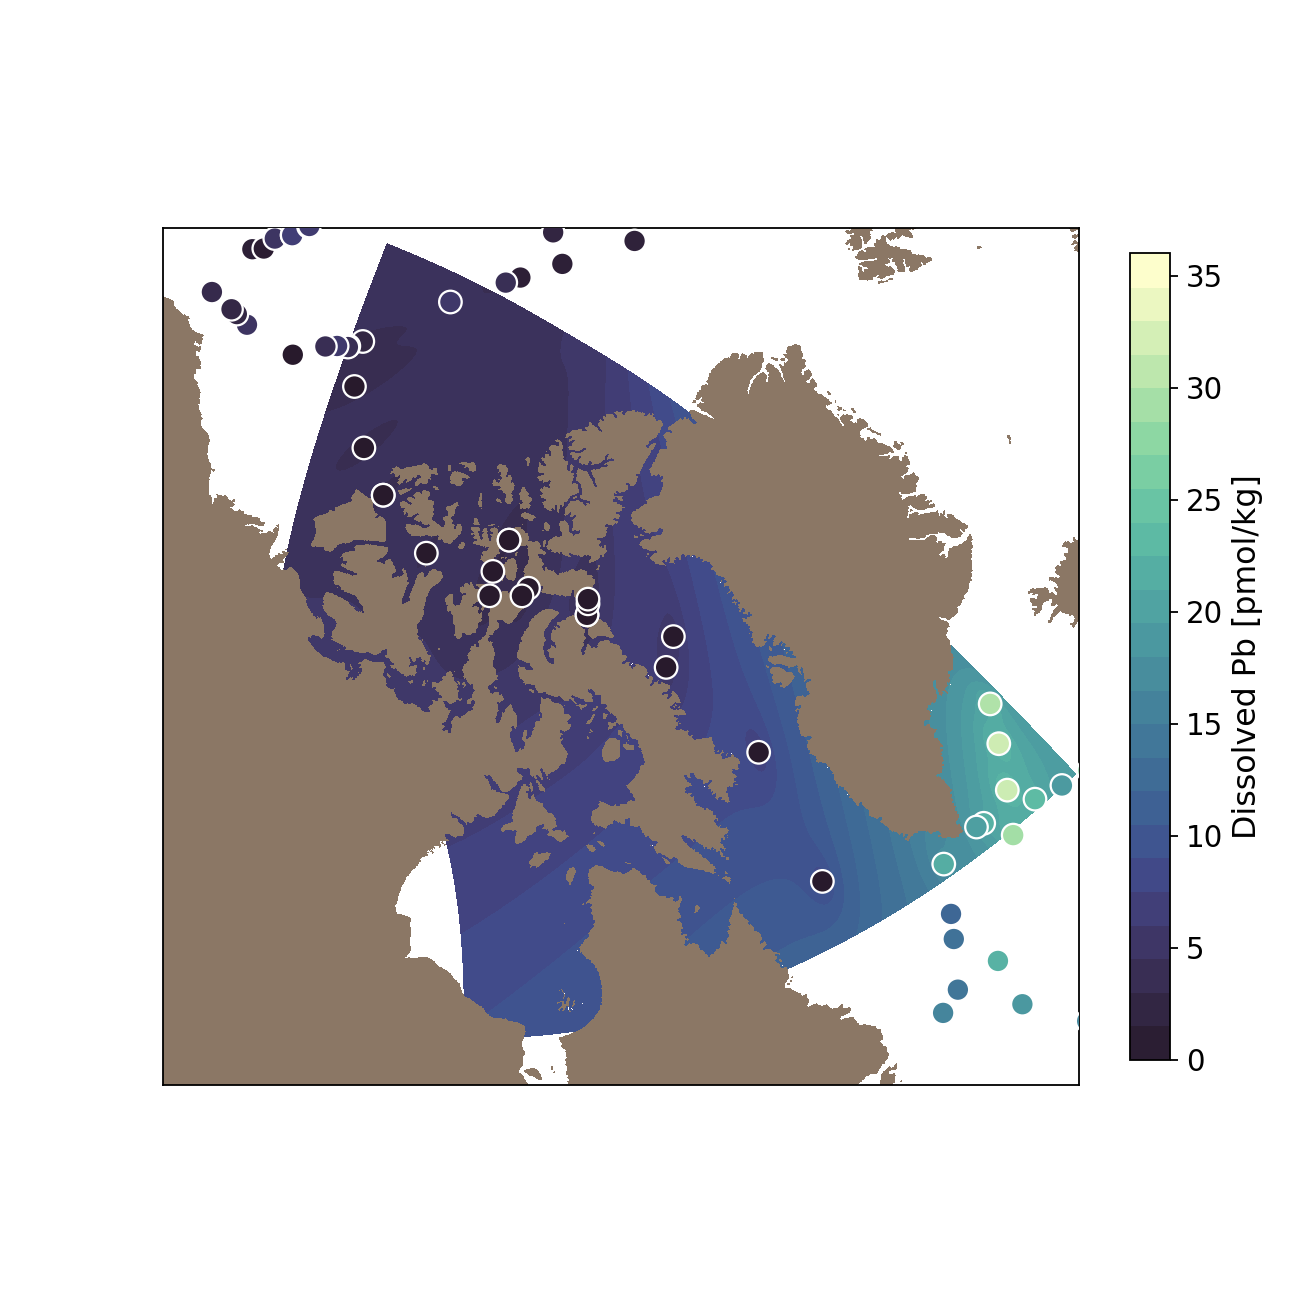

<IPython.core.display.Javascript object>

In [22]:
plot_krig(xx_yes,yy_yes,Z_yes,stns_yes,dpb_yes, 35)

Not using the CAA stations:

In [23]:
xx_no, yy_no, Z_no, stns_no, dpb_no = krig([0, 20])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


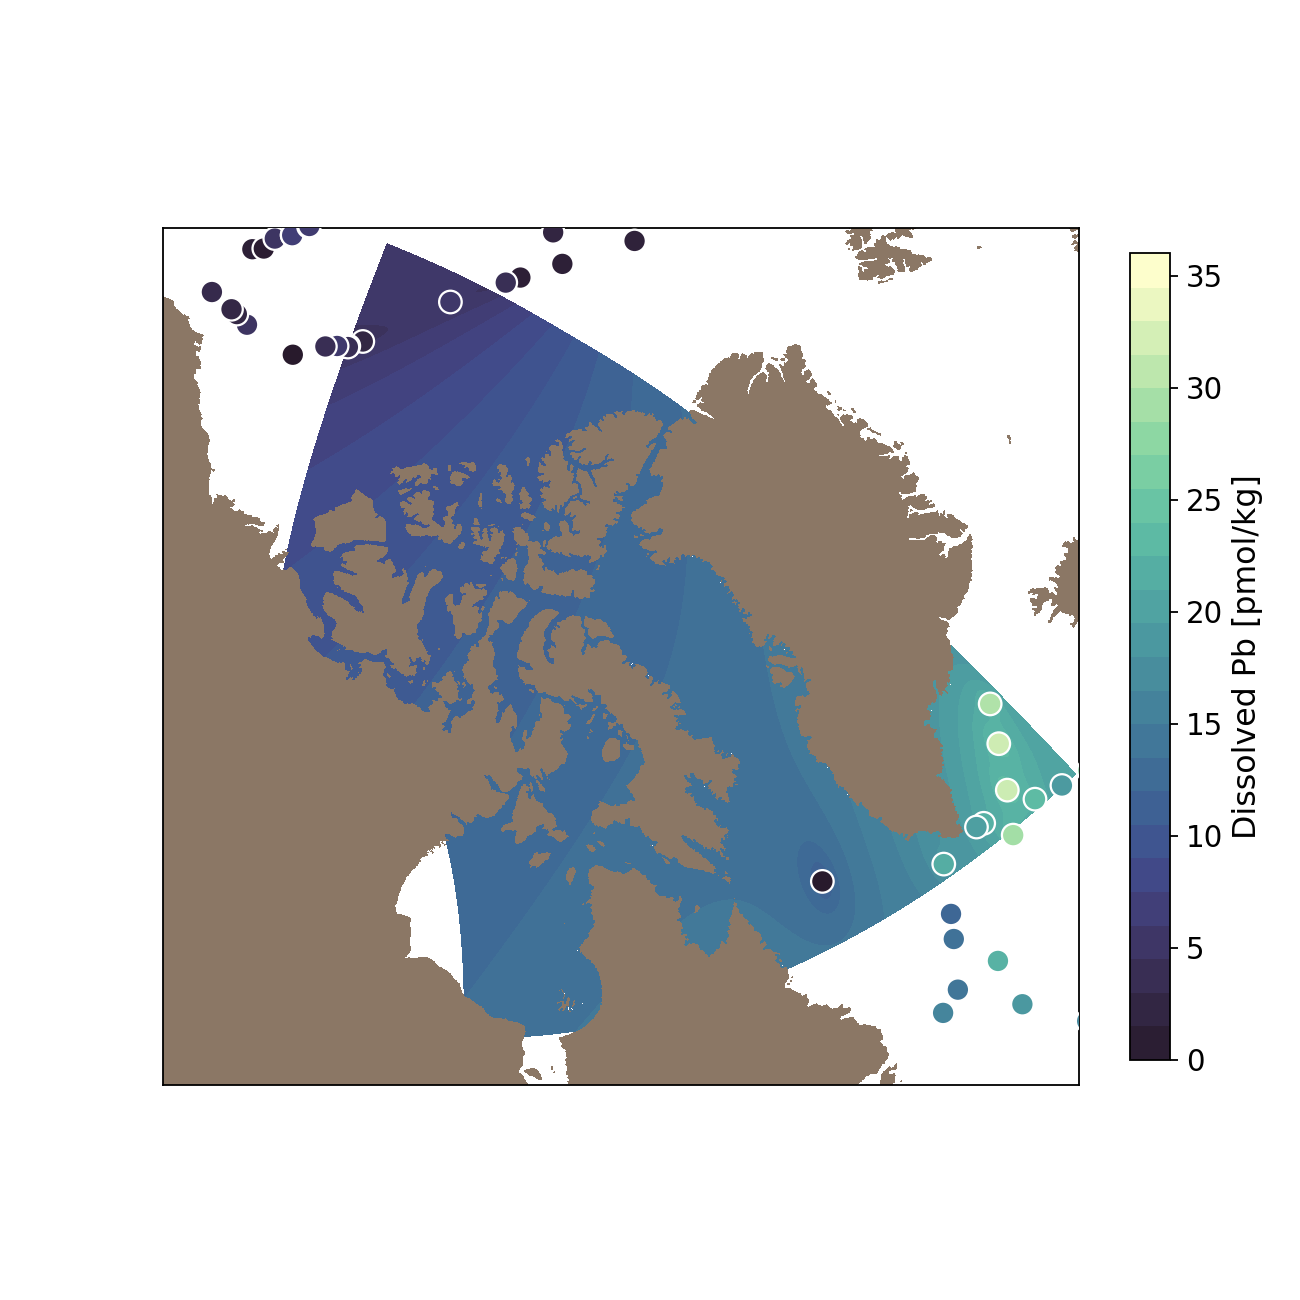

In [24]:
plot_krig(xx_no,yy_no,Z_no,stns_no,dpb_no, 35)

# Create the 3D initial conditions

Surface: 0 to 10 m

In [25]:
xx1, yy1, Z1, stns1, dpb1 = krig([0, 10])

<IPython.core.display.Javascript object>


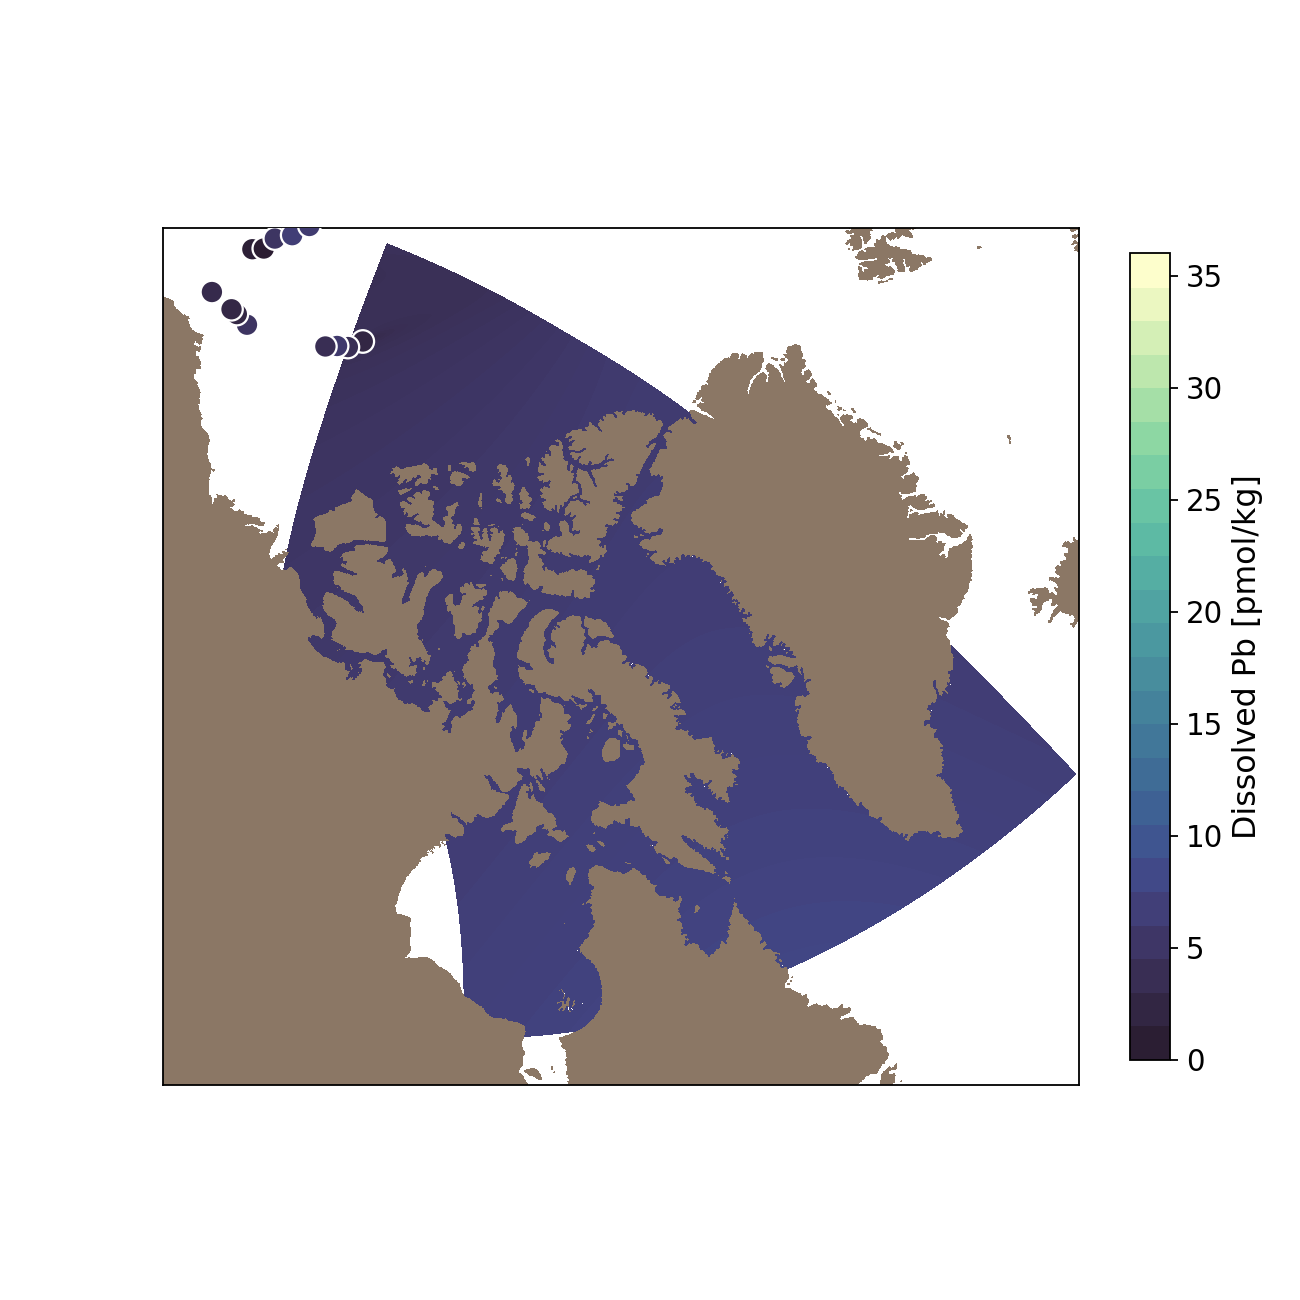

<IPython.core.display.Javascript object>

In [26]:
plot_krig(xx1,yy1,Z1,stns1,dpb1, 35)

10-20 m:

In [27]:
xx11, yy11, Z11, stns11, dpb11 = krig([10, 20])

<IPython.core.display.Javascript object>


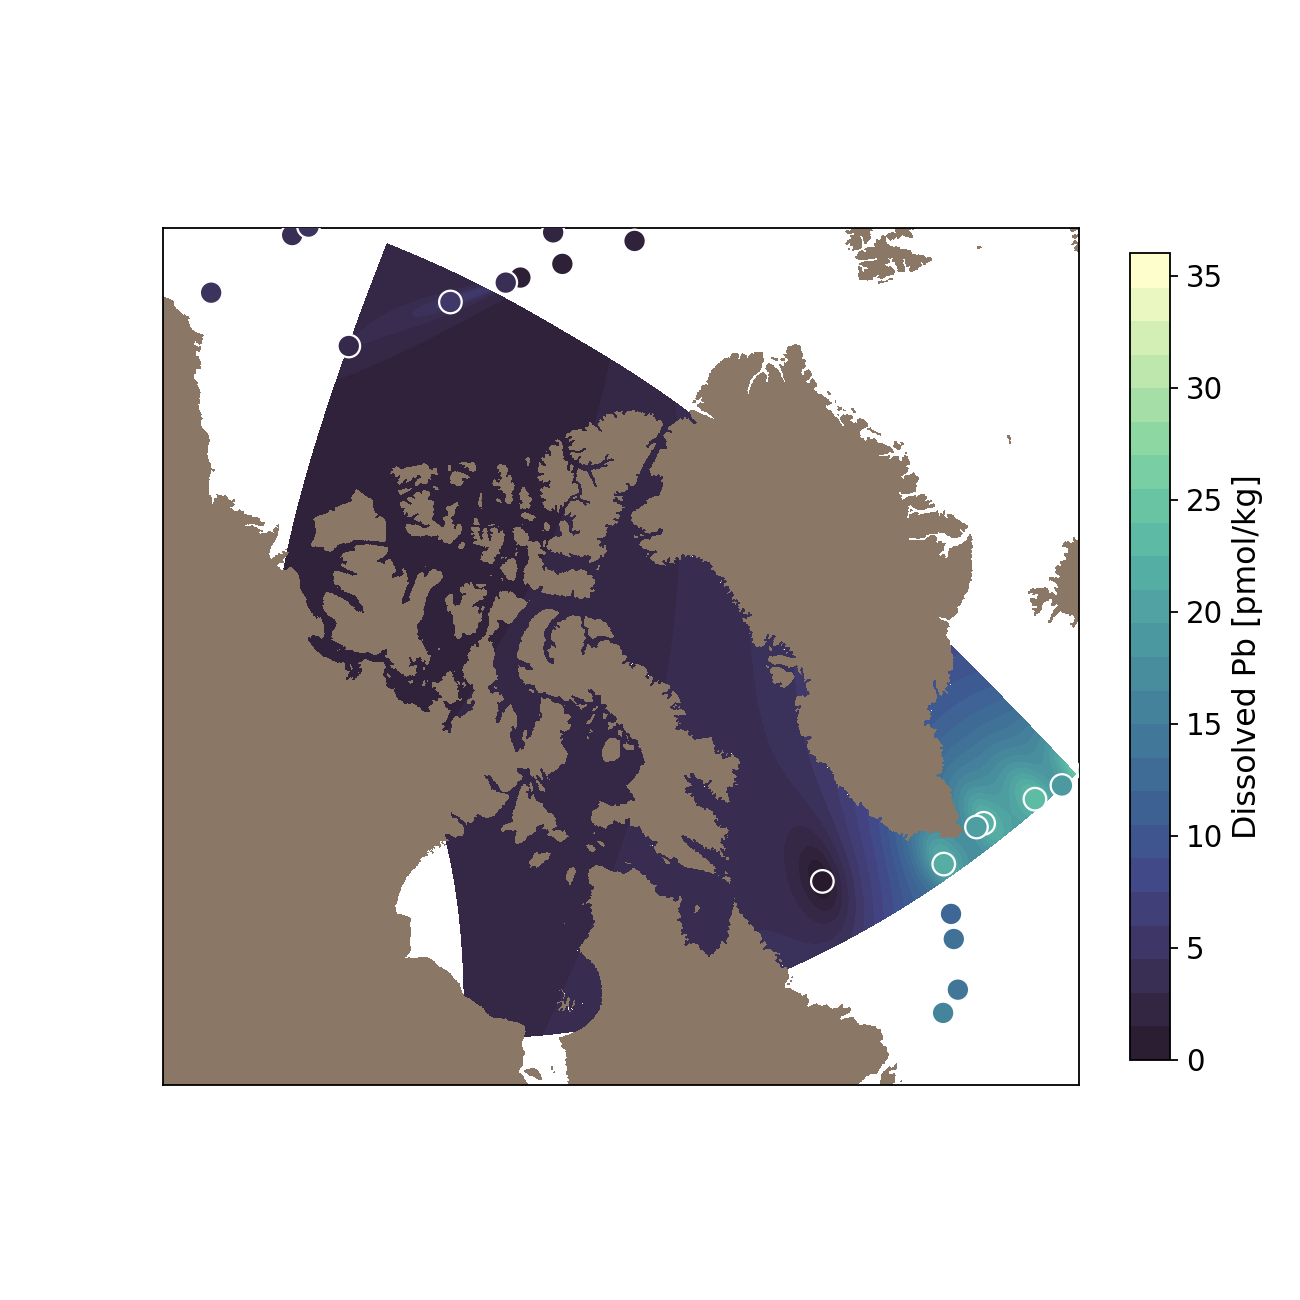

<IPython.core.display.Javascript object>

In [28]:
plot_krig(xx11,yy11,Z11,stns11,dpb11, 35)

20-50 m:

In [31]:
xx2, yy2, Z2, stns2, dpb2 = krig([22, 47])

<IPython.core.display.Javascript object>


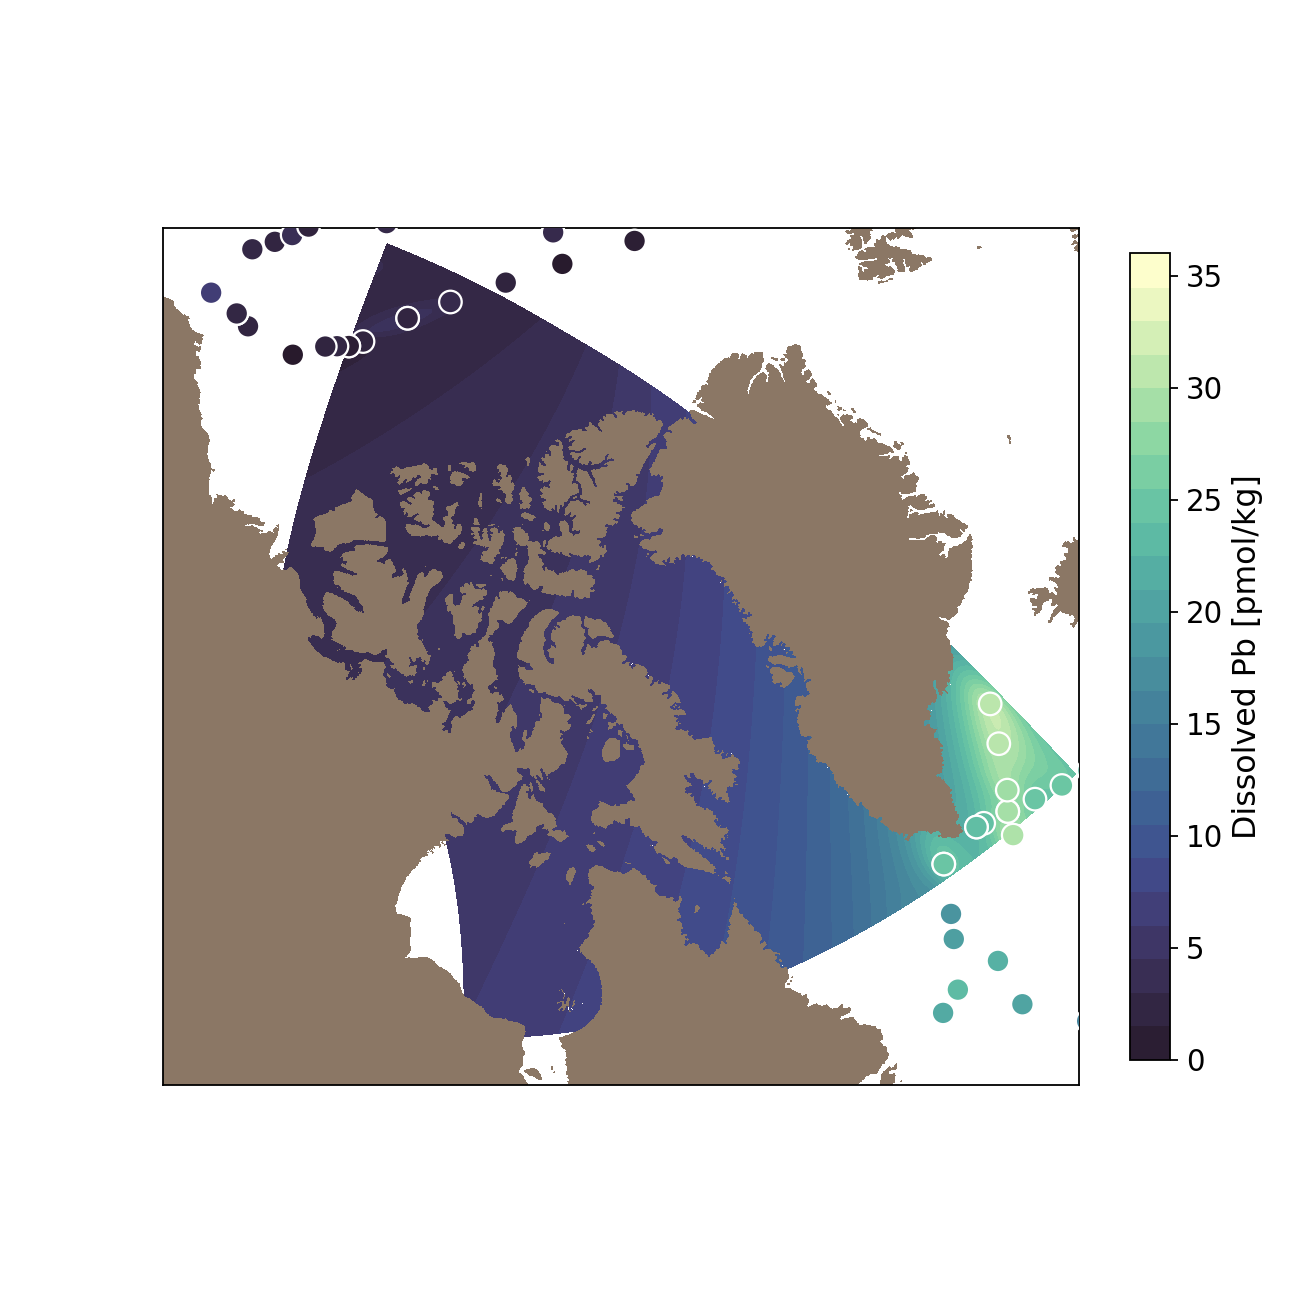

<IPython.core.display.Javascript object>

In [32]:
plot_krig(xx2,yy2,Z2,stns2,dpb2, 35)

50-100 m:

In [33]:
xx3, yy3, Z3, stns3, dpb3 = krig([50, 105])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


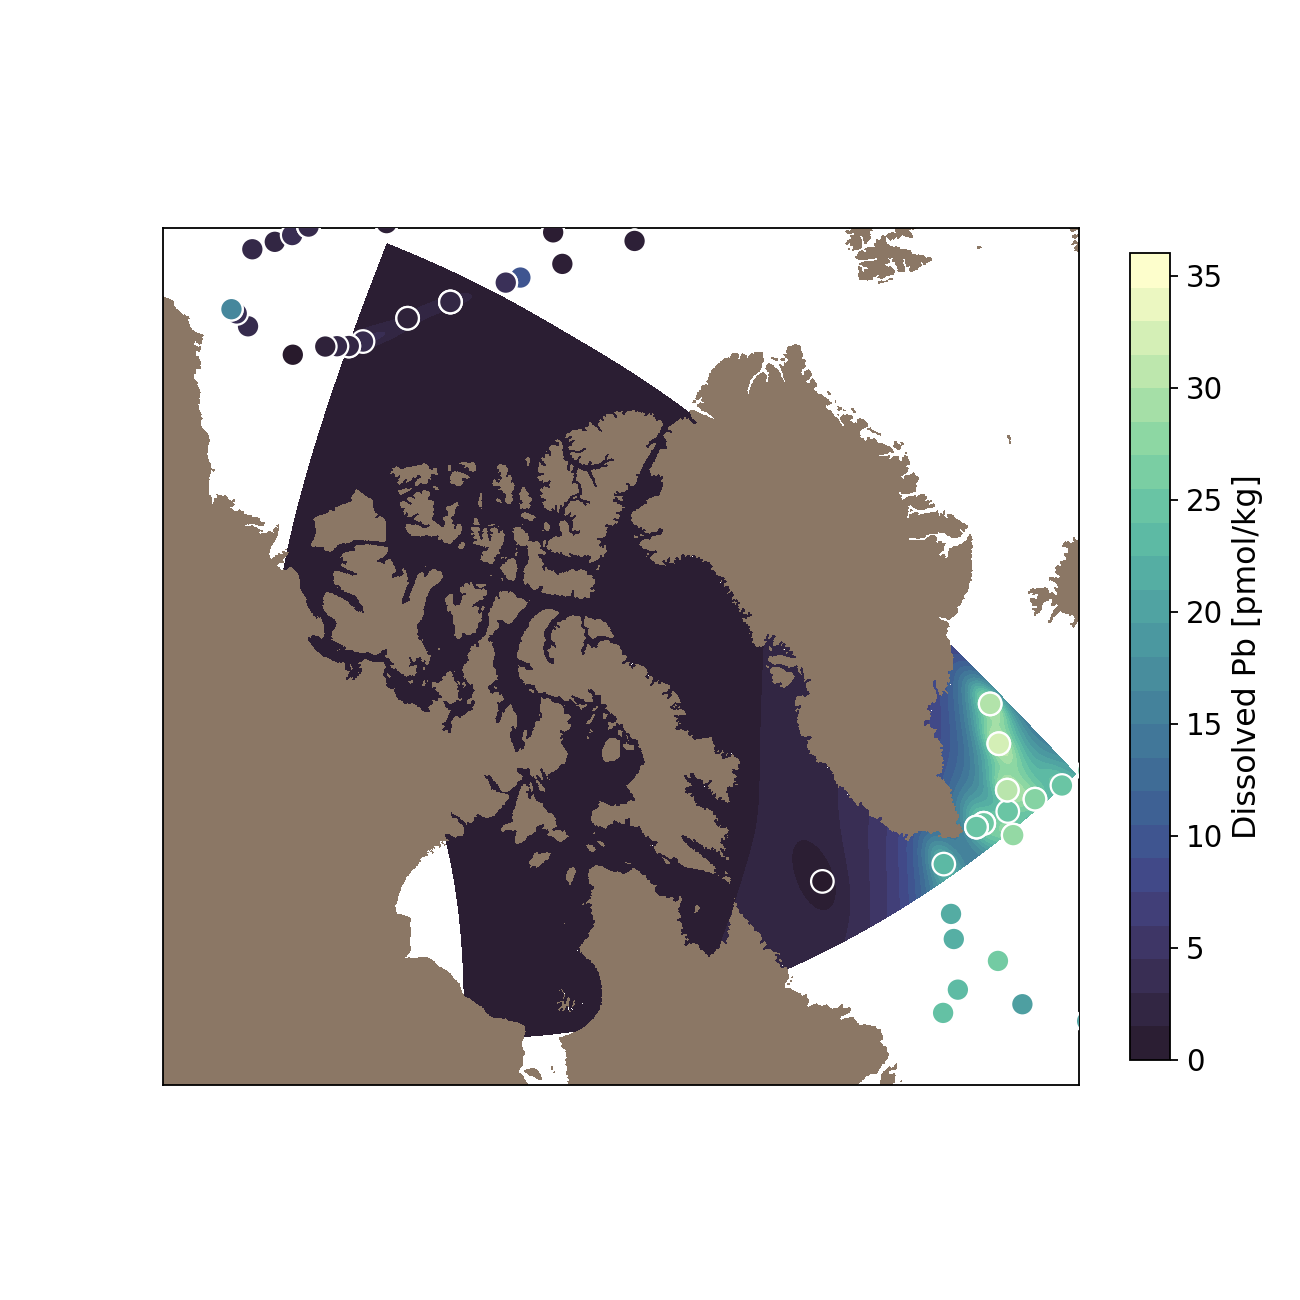

In [34]:
plot_krig(xx3,yy3,Z3,stns3,dpb3, 35)

100-400 m:

In [50]:
xx4, yy4, Z4, stns4, dpb4 = krig([110, 380])

/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4753280., -5634304.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4753280., -5634304.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)


<IPython.core.display.Javascript object>


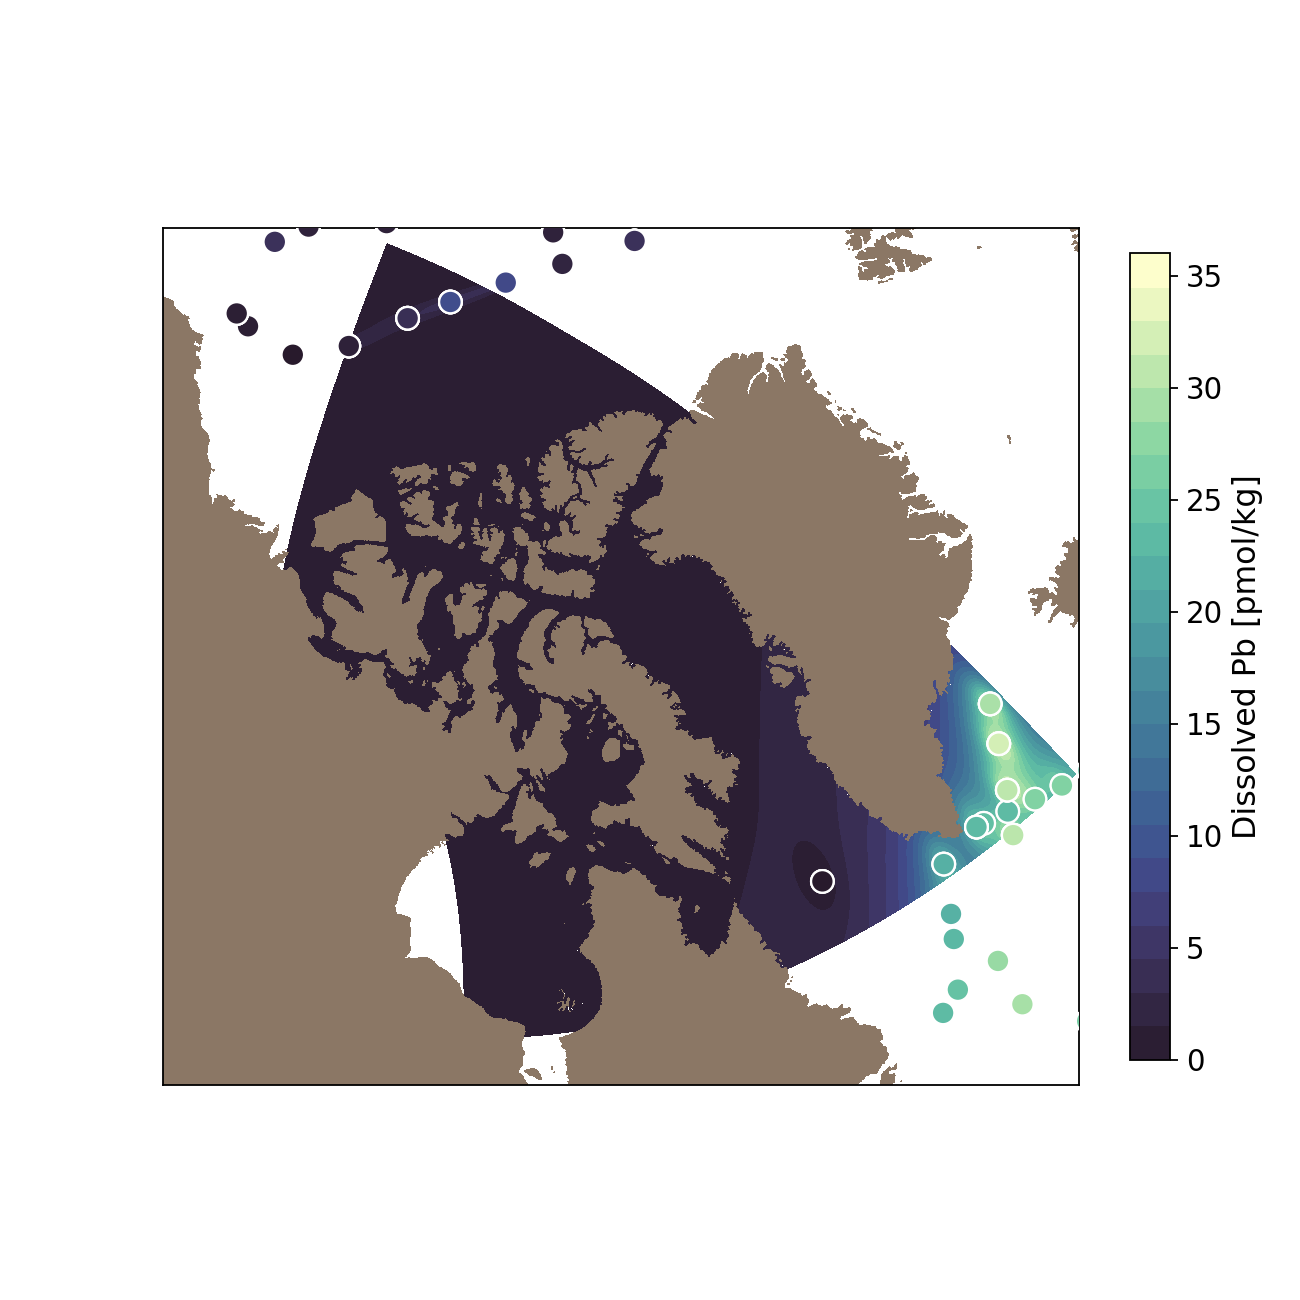

<IPython.core.display.Javascript object>

In [51]:
plot_krig(xx4,yy4,Z4,stns4,dpb4, 35)

400-800 m:

In [35]:
xx5, yy5, Z5, stns5, dpb5 = krig([400, 902])

/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 114688., 7471104.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)
/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 114688., 7471104.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)


<IPython.core.display.Javascript object>


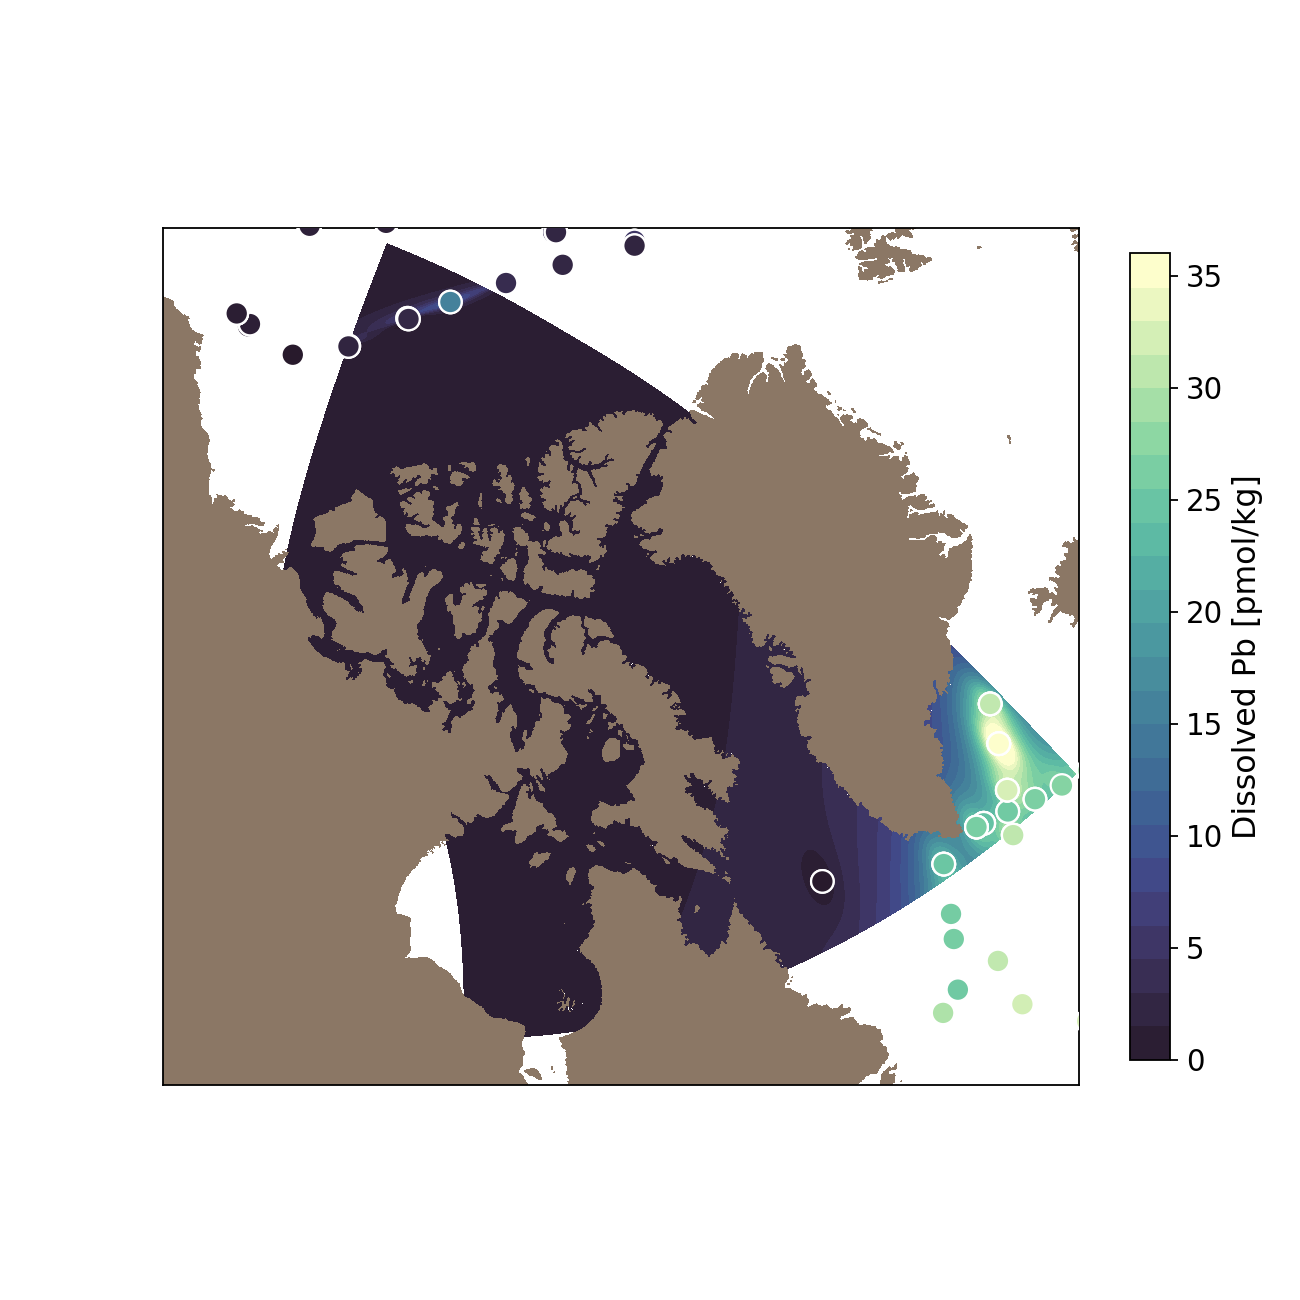

<IPython.core.display.Javascript object>

In [36]:
plot_krig(xx5,yy5,Z5,stns5,dpb5, 35)

900-1200 m:

In [37]:
xx6, yy6, Z6, stns6, dpb6 = krig([902, 1245])

<IPython.core.display.Javascript object>


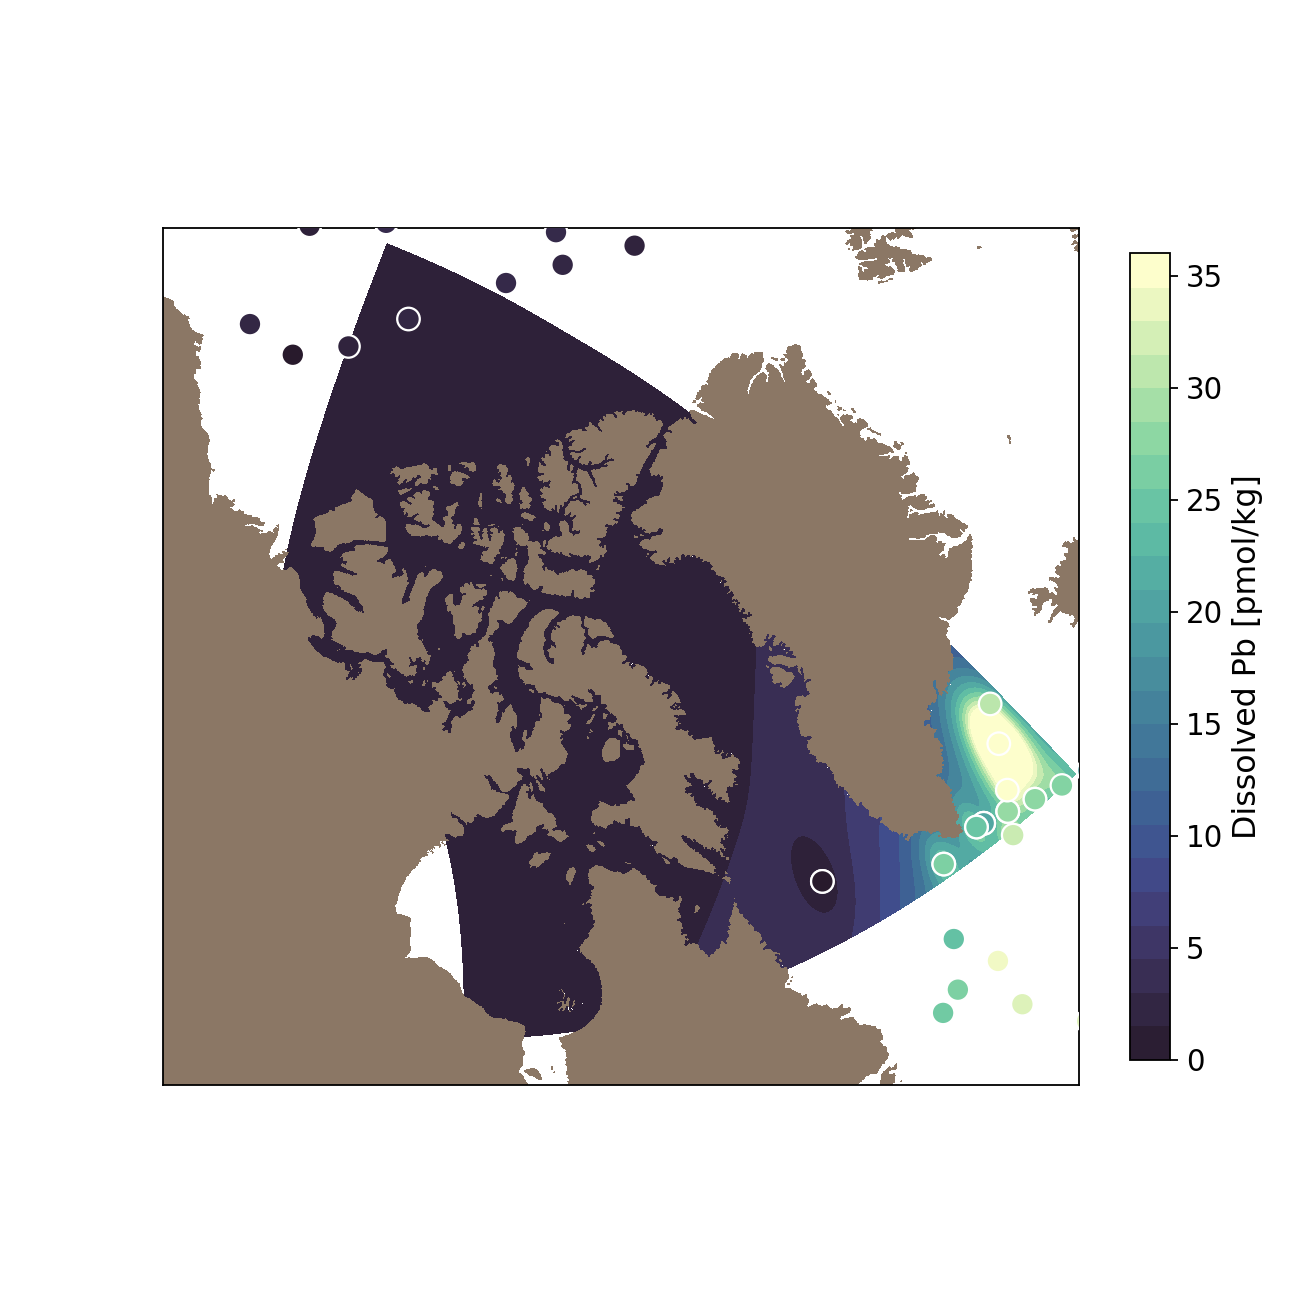

<IPython.core.display.Javascript object>

In [38]:
plot_krig(xx6,yy6,Z6,stns6,dpb6, 35)

1200-2000 m:

In [39]:
xx8, yy8, Z8, stns8, dpb8 = krig([1260, 1940])

<IPython.core.display.Javascript object>


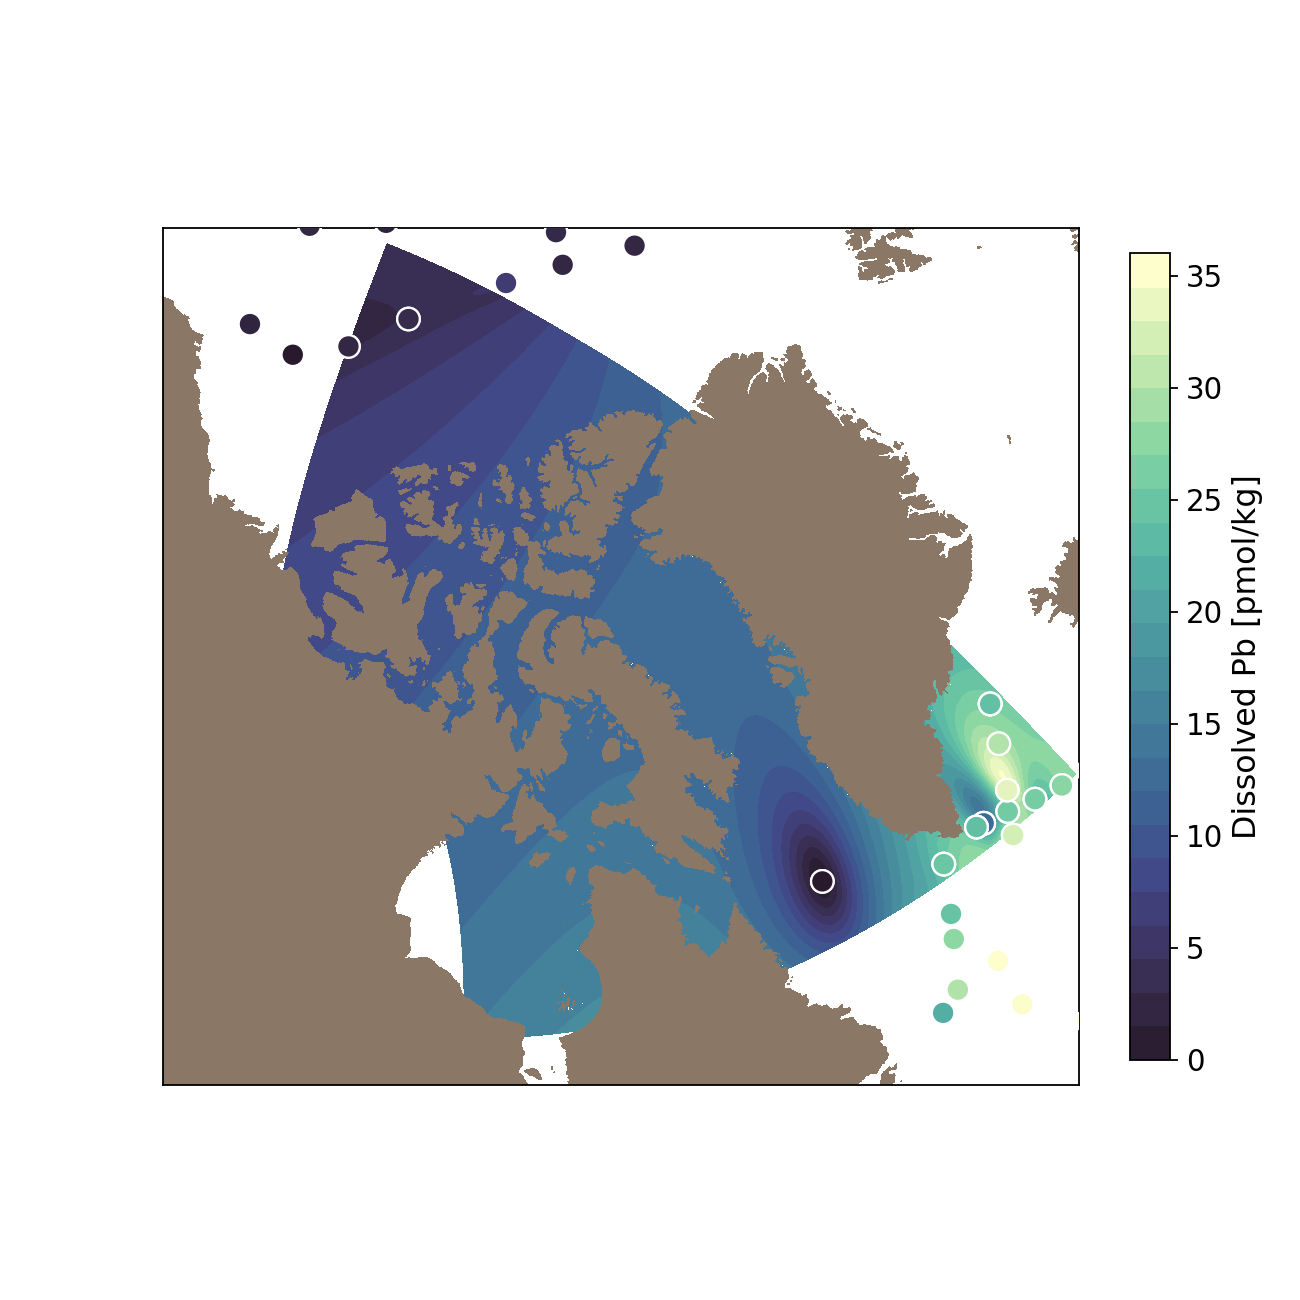

<IPython.core.display.Javascript object>

In [40]:
plot_krig(xx8,yy8,Z8,stns8,dpb8, 35)

2000-3000 m

In [41]:
xx7, yy7, Z7, stns7, dpb7 = krig([1940, 3221])

/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2539520., -10031104.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  2539520., -10031104.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)


<IPython.core.display.Javascript object>


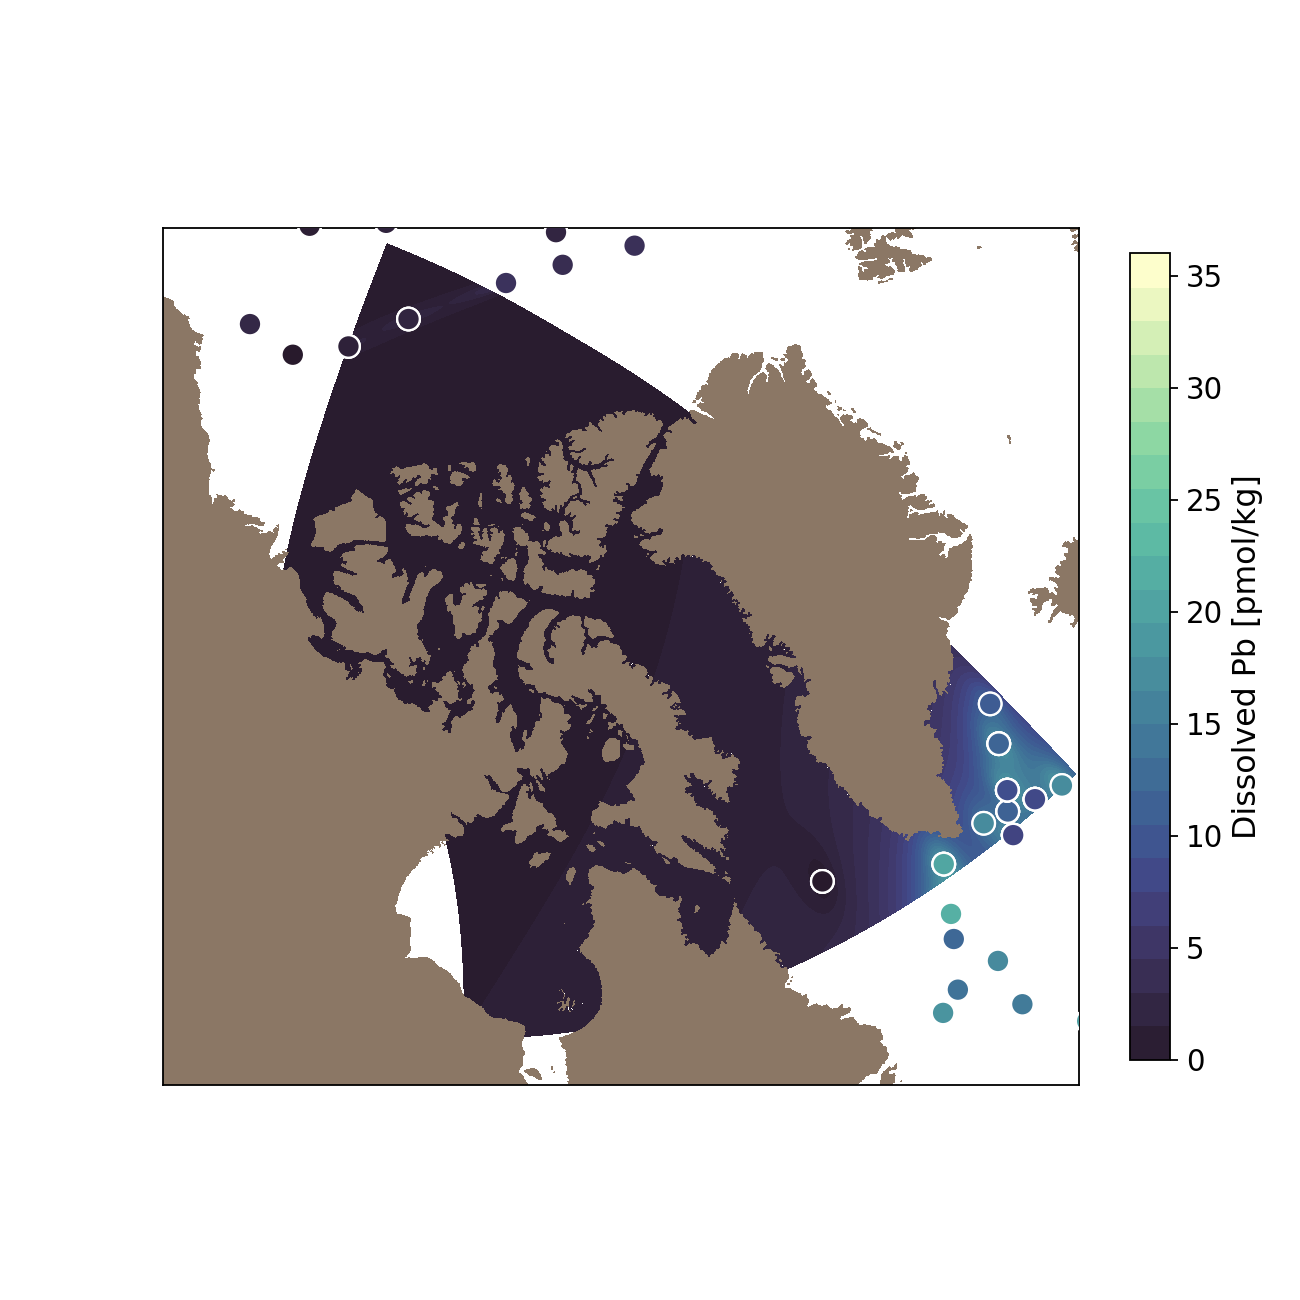

<IPython.core.display.Javascript object>

In [42]:
plot_krig(xx7,yy7,Z7,stns7,dpb7, 35)

Below 3000 m:

In [43]:
xx9, yy9, Z9, stns9, dpb9 = krig([3221, 5730])

/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-995328.,  415744.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/home/brogalla/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-995328.,  415744.]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


<IPython.core.display.Javascript object>


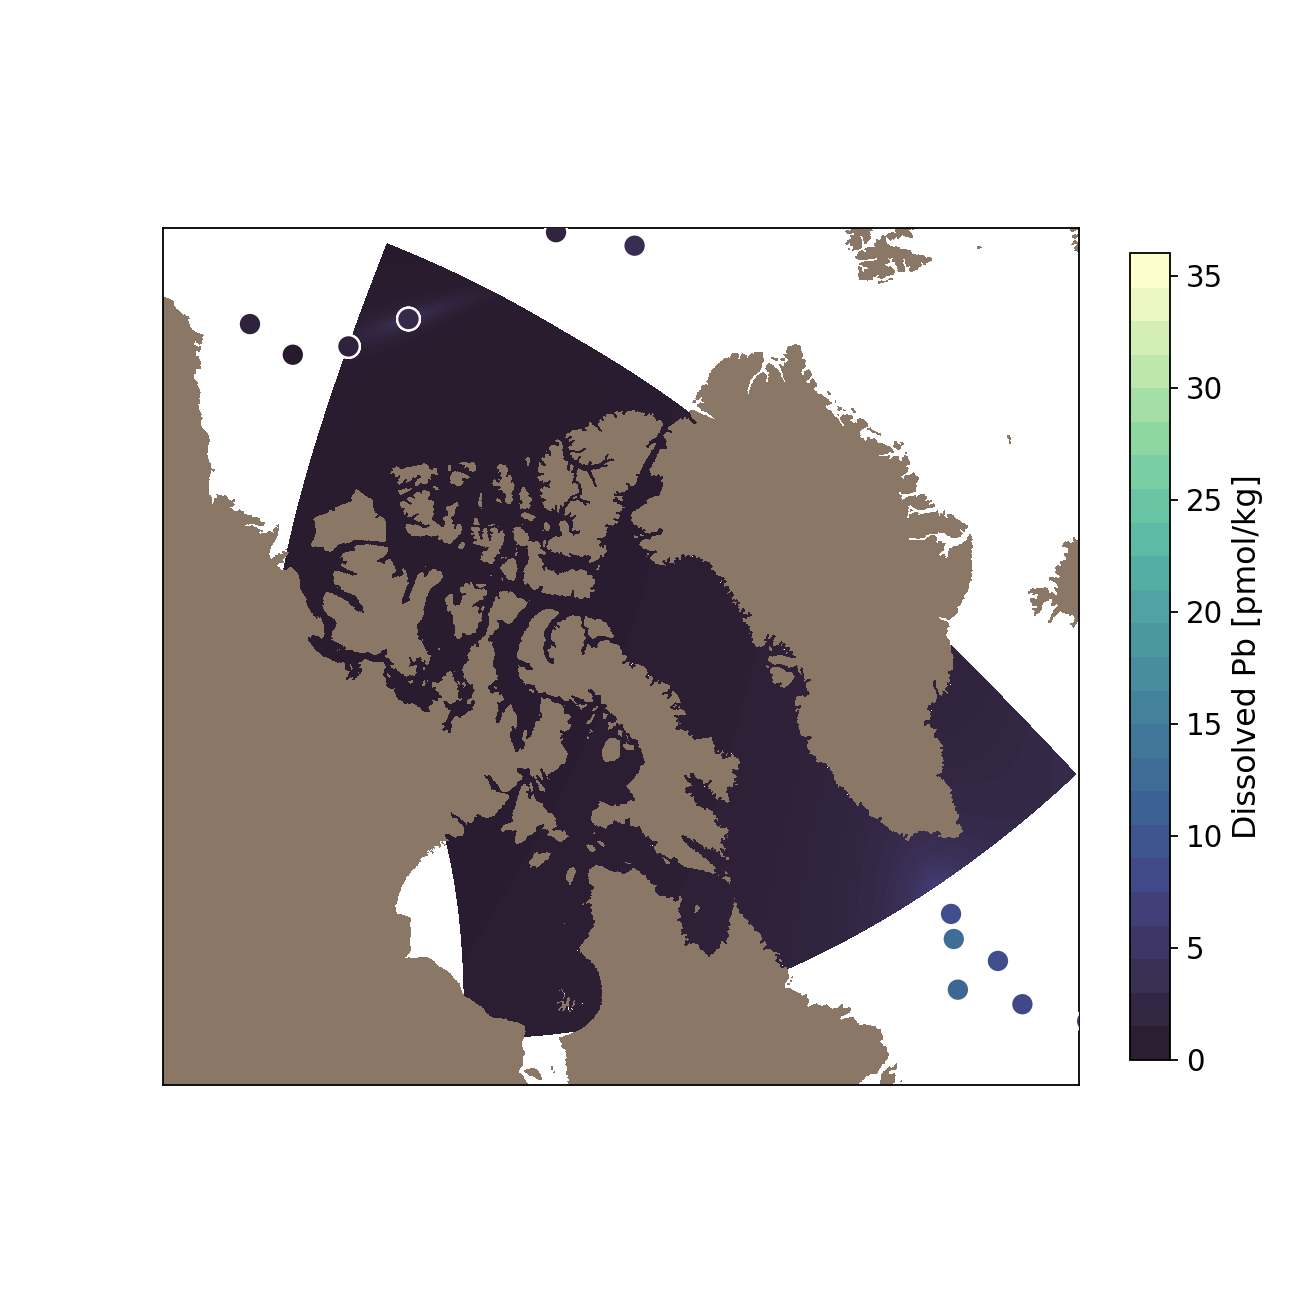

<IPython.core.display.Javascript object>

In [44]:
plot_krig(xx9,yy9,Z9,stns9,dpb9, 35)

Add these fields to the initial condition array:

| Variable | Depth range (m) | Model depth levels |
|----------|-----------------|--------------------|
| Z1       | 0-10            | 1-8                |
| Z11      | 10-22           | 9-13               |
| Z2       | 22-47           | 14-18              |
| Z3       | 47-110          | 19-23              |
| Z4       | 110-380         | 24-30              |
| Z5       | 400-902         | 31-35              |
| Z6       | 902-1245        | 36-37              |
| Z8       | 1245-1940       | 38-40              |
| Z7       | 1940-3221       | 41-44              |
| Z9       | 3221-5730       | 45-50              |

In [59]:
ini_pb = np.empty((1,50,2400,1632))
ini_pb.fill(3)

Surface concentrations estimated by Kriging:

In [60]:
# Surface concentrations estimated by Kriging:
for i in range(0,50):
    if i < 8:
        ini_pb[0,i,1100:2050,160:800] = Z1
    elif 8 < i < 13:
        ini_pb[0,i,1100:2050,160:800] = Z11
    elif 13 < i < 18:
        ini_pb[0,i,1100:2050,160:800] = Z2
    elif 18 < i < 23:
        ini_pb[0,i,1100:2050,160:800] = Z3
    elif 23 < i < 30:
        ini_pb[0,i,1100:2050,160:800] = Z4
    elif 30 < i < 35:
        ini_pb[0,i,1100:2050,160:800] = Z5
    elif 35 < i < 37:
        ini_pb[0,i,1100:2050,160:800] = Z6
    elif 37 < i < 40:
        ini_pb[0,i,1100:2050,160:800] = Z8
    elif 40 < i < 44:
        ini_pb[0,i,1100:2050,160:800] = Z7
    elif 44 < i < 50:
        ini_pb[0,i,1100:2050,160:800] = Z9

In [61]:
ini_pb[ini_pb < 0] = 3

In [62]:
print(np.average(ini_pb), np.amax(ini_pb), np.amin(ini_pb))

3.0555466150417514 75.73148393630981 0.0003223419189453125
3.0555466150417514 75.73148393630981 0.0003223419189453125


### Write NetCDF file:

In [63]:
# Check whether any of the values are NaN:
print(np.count_nonzero(np.isnan(ini_pb)))

0
0


In [69]:
# Setup the new NetCDF file:
ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_ini-20190916.nc', 'w', zlib=True)
ncd.createDimension('x',len(mesh.dimensions['x']))
ncd.createDimension('y',len(mesh.dimensions['y']))
ncd.createDimension('deptht',50)
ncd.createDimension('time_counter',None)

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0

In [70]:
# variables
dpb_var = ncd.createVariable('dPb', 'float64', ('time_counter','deptht','y','x'))
dpb_var.units = 'kmol/m3'
dpb_var.long_name = 'Dissolved Pb concentration IC'  
dpb_var.coordinates = 'nav_lon nav_lat deptht time_counter'
dpb_var[:,:,:,:] = ini_pb

In [71]:
ncd.close()